# Part 3.3

Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL-STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible

Comparison between the models : 
+ (+)RNNs process data in a sequential manner (one direction); they retain information from previous steps but can struggle to remember distant information due to issues like vanishing gradients.
- (-)RNNs fail to capture long-term dependencies, especially in long sequences, as the information fades over time, and gradients vanish during backpropagation through time. Limits effectiveness in tasks requiring model to remember information over many time steps.
-----------------------------------------------
- (+)BiLSTM : Bidirectional Long Short-Term Memory, a RNN, handle long term dependencies better. It has gates that help regulate flow of information, enabling them to retain or discard information as needed.

- BiLSTM consists of 2 LSTM layers running in opposite directions : 1 processes sequence from past to future, while other processes it from future to past : captures both past and future context for each time step 

- BiLSTM helps to capture context from both directions, beneficial in tasks where understanding context of each word is important

- (-) BiLSTMs are computationally more intensive than regular LSTMs and RNNs due to bidirectional component and complexity of gating mechanism
-----------------------------------------------
- (+)BiGRU, type of RNN, has 2 gates instead of 3 used by LSTMS - makes GRUs faster to computer while still handling long-term dependencies better than traditional RNNs. Includes 2 GRU layers, one running forward one running backward, learnign both past and present context. 

- BiGRUs achieve similar performance to BiLSTMs but with fewer parameters and faster computation, making them more efficient for large datasets 

- (-)Although GRUs generally simpler and faster, might be less expressive in certain cases due to absence of output gate

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# biL-STM model

In [8]:
MODEL_TYPE = "lstm"
LR = 0.0001

## Last State LSTM

### 2 layers

In [9]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [10]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="last_state",
    freeze_embeddings=False
)

In [11]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5131
Model saved.
Epoch   2/100, Loss: 0.6401, Accuracy: 0.7129
Model saved.
Epoch   3/100, Loss: 0.3795, Accuracy: 0.7111
Epoch   4/100, Loss: 0.2285, Accuracy: 0.7176
Model saved.
Epoch   5/100, Loss: 0.1400, Accuracy: 0.7139
Epoch   6/100, Loss: 0.0914, Accuracy: 0.7186
Model saved.
Epoch   7/100, Loss: 0.0629, Accuracy: 0.7223
Model saved.
Epoch   8/100, Loss: 0.0416, Accuracy: 0.7223
Epoch   9/100, Loss: 0.0382, Accuracy: 0.7120
Epoch  10/100, Loss: 0.0278, Accuracy: 0.7092
Epoch  11/100, Loss: 0.0218, Accuracy: 0.7026
Epoch  12/100, Loss: 0.0195, Accuracy: 0.7111
Epoch  13/100, Loss: 0.0125, Accuracy: 0.7083
Epoch  14/100, Loss: 0.0106, Accuracy: 0.7101
Epoch  15/100, Loss: 0.0079, Accuracy: 0.7054
Epoch  16/100, Loss: 0.0076, Accuracy: 0.7064
Epoch  17/100, Loss: 0.0101, Accuracy: 0.7054
Early stopping triggered after 17 epochs.
Training ended, loading best model...
Model loaded.


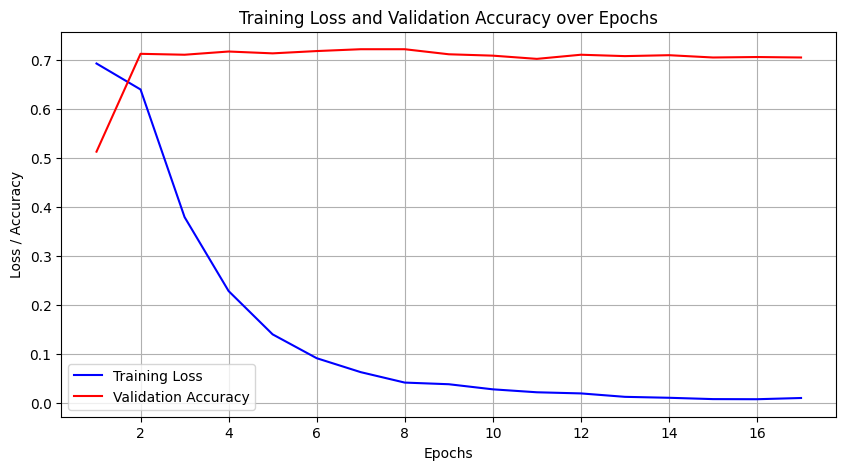

In [12]:
plot_loss_accuracy(losses, accuracies)

In [13]:
last_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7439


### 4 layers

Trying with an increased number of stack layers

In [14]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [15]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="last_state",
    freeze_embeddings=False
)

In [16]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6928, Accuracy: 0.5854
Model saved.
Epoch   2/100, Loss: 0.5685, Accuracy: 0.7129
Model saved.
Epoch   3/100, Loss: 0.3350, Accuracy: 0.7148
Model saved.
Epoch   4/100, Loss: 0.2112, Accuracy: 0.7111
Epoch   5/100, Loss: 0.1353, Accuracy: 0.7261
Model saved.
Epoch   6/100, Loss: 0.0890, Accuracy: 0.7120
Epoch   7/100, Loss: 0.0571, Accuracy: 0.7158
Epoch   8/100, Loss: 0.0440, Accuracy: 0.7186
Epoch   9/100, Loss: 0.0288, Accuracy: 0.6970
Epoch  10/100, Loss: 0.0206, Accuracy: 0.7298
Model saved.
Epoch  11/100, Loss: 0.0202, Accuracy: 0.7120
Epoch  12/100, Loss: 0.0146, Accuracy: 0.7139
Epoch  13/100, Loss: 0.0145, Accuracy: 0.7195
Epoch  14/100, Loss: 0.0189, Accuracy: 0.7195
Epoch  15/100, Loss: 0.0141, Accuracy: 0.7214
Epoch  16/100, Loss: 0.0092, Accuracy: 0.7186
Epoch  17/100, Loss: 0.0121, Accuracy: 0.7176
Epoch  18/100, Loss: 0.0105, Accuracy: 0.7120
Epoch  19/100, Loss: 0.0127, Accuracy: 0.7008
Epoch  20/100, Loss: 0.0087, Accuracy: 0.7064
Early stopping 

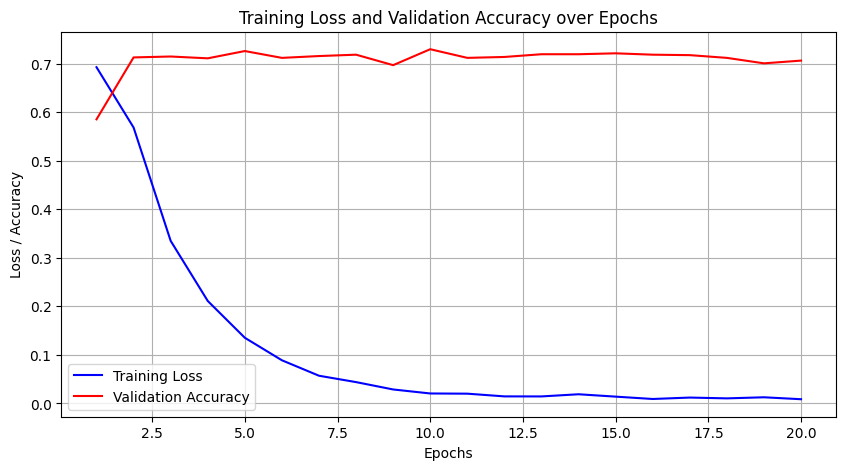

In [17]:
plot_loss_accuracy(losses, accuracies)

In [18]:
last_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7627


## Mean Max Pooling


### 2 layers

In [19]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [20]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_max",
    freeze_embeddings=False
)

In [21]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6919, Accuracy: 0.5704
Model saved.
Epoch   2/100, Loss: 0.5401, Accuracy: 0.7251
Model saved.
Epoch   3/100, Loss: 0.3239, Accuracy: 0.7214
Epoch   4/100, Loss: 0.2066, Accuracy: 0.7148
Epoch   5/100, Loss: 0.1364, Accuracy: 0.7111
Epoch   6/100, Loss: 0.0843, Accuracy: 0.7214
Epoch   7/100, Loss: 0.0549, Accuracy: 0.7223
Epoch   8/100, Loss: 0.0388, Accuracy: 0.7120
Epoch   9/100, Loss: 0.0296, Accuracy: 0.7148
Epoch  10/100, Loss: 0.0264, Accuracy: 0.7195
Epoch  11/100, Loss: 0.0186, Accuracy: 0.7083
Epoch  12/100, Loss: 0.0149, Accuracy: 0.7026
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


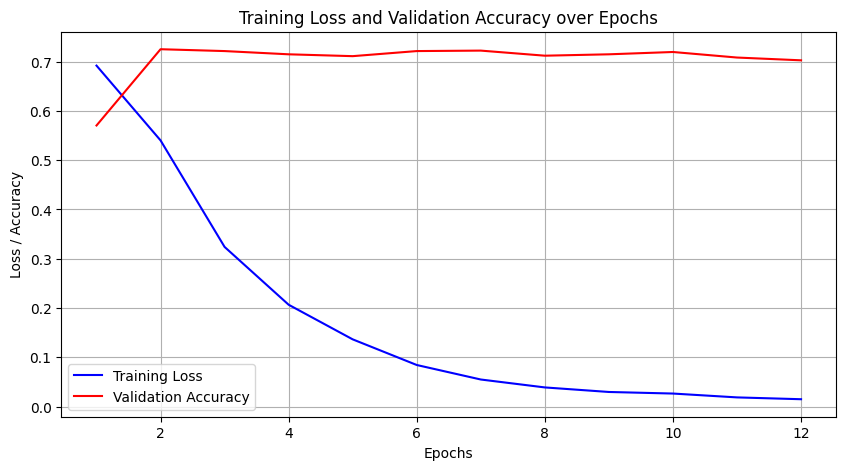

In [22]:
plot_loss_accuracy(losses, accuracies)

In [23]:
mean_max_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7570


### 4 layers

In [24]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [25]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # set to 4 for stacking multiple layers
    pooling_method="mean_max",
    freeze_embeddings=False
)

In [26]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6925, Accuracy: 0.6088
Model saved.
Epoch   2/100, Loss: 0.5271, Accuracy: 0.7298
Model saved.
Epoch   3/100, Loss: 0.3143, Accuracy: 0.7308
Model saved.
Epoch   4/100, Loss: 0.1983, Accuracy: 0.7223
Epoch   5/100, Loss: 0.1288, Accuracy: 0.7139
Epoch   6/100, Loss: 0.0809, Accuracy: 0.7083
Epoch   7/100, Loss: 0.0556, Accuracy: 0.7167
Epoch   8/100, Loss: 0.0387, Accuracy: 0.7073
Epoch   9/100, Loss: 0.0338, Accuracy: 0.7129
Epoch  10/100, Loss: 0.0274, Accuracy: 0.7139
Epoch  11/100, Loss: 0.0209, Accuracy: 0.7101
Epoch  12/100, Loss: 0.0226, Accuracy: 0.7054
Epoch  13/100, Loss: 0.0208, Accuracy: 0.7148
Early stopping triggered after 13 epochs.
Training ended, loading best model...
Model loaded.


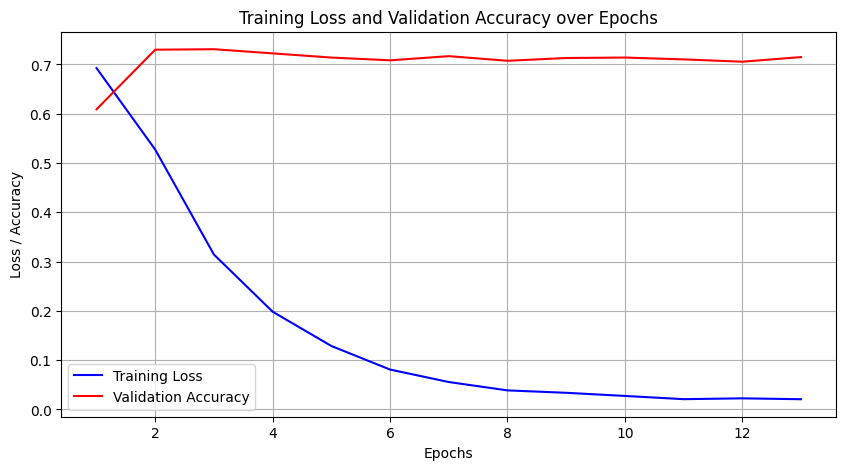

In [27]:
plot_loss_accuracy(losses, accuracies)

In [28]:
mean_max_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7523


## Attention


### 2 layers

In [29]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [30]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="attention",
    freeze_embeddings=False
)

In [31]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6913, Accuracy: 0.6098
Model saved.
Epoch   2/100, Loss: 0.5316, Accuracy: 0.7186
Model saved.
Epoch   3/100, Loss: 0.3200, Accuracy: 0.7233
Model saved.
Epoch   4/100, Loss: 0.2041, Accuracy: 0.7242
Model saved.
Epoch   5/100, Loss: 0.1275, Accuracy: 0.7261
Model saved.
Epoch   6/100, Loss: 0.0810, Accuracy: 0.7195
Epoch   7/100, Loss: 0.0529, Accuracy: 0.7120
Epoch   8/100, Loss: 0.0374, Accuracy: 0.7120
Epoch   9/100, Loss: 0.0306, Accuracy: 0.7111
Epoch  10/100, Loss: 0.0240, Accuracy: 0.7092
Epoch  11/100, Loss: 0.0152, Accuracy: 0.7120
Epoch  12/100, Loss: 0.0201, Accuracy: 0.7073
Epoch  13/100, Loss: 0.0170, Accuracy: 0.6932
Epoch  14/100, Loss: 0.0155, Accuracy: 0.7129
Epoch  15/100, Loss: 0.0131, Accuracy: 0.7101
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


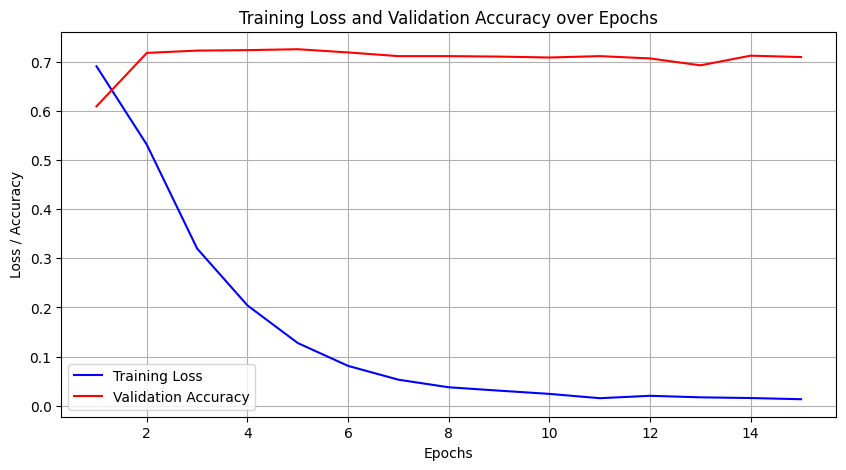

In [32]:
plot_loss_accuracy(losses, accuracies)

In [33]:
attention_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7505


### 4 layers

In [34]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [35]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # set to 4 for stacking multiple layers
    pooling_method="attention",
    freeze_embeddings=False
)

In [36]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6881, Accuracy: 0.6210
Model saved.
Epoch   2/100, Loss: 0.5095, Accuracy: 0.7317
Model saved.
Epoch   3/100, Loss: 0.3087, Accuracy: 0.7148
Epoch   4/100, Loss: 0.1946, Accuracy: 0.7092
Epoch   5/100, Loss: 0.1217, Accuracy: 0.7148
Epoch   6/100, Loss: 0.0757, Accuracy: 0.7045
Epoch   7/100, Loss: 0.0620, Accuracy: 0.7148
Epoch   8/100, Loss: 0.0431, Accuracy: 0.7139
Epoch   9/100, Loss: 0.0282, Accuracy: 0.7111
Epoch  10/100, Loss: 0.0257, Accuracy: 0.7045
Epoch  11/100, Loss: 0.0146, Accuracy: 0.7045
Epoch  12/100, Loss: 0.0160, Accuracy: 0.7092
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


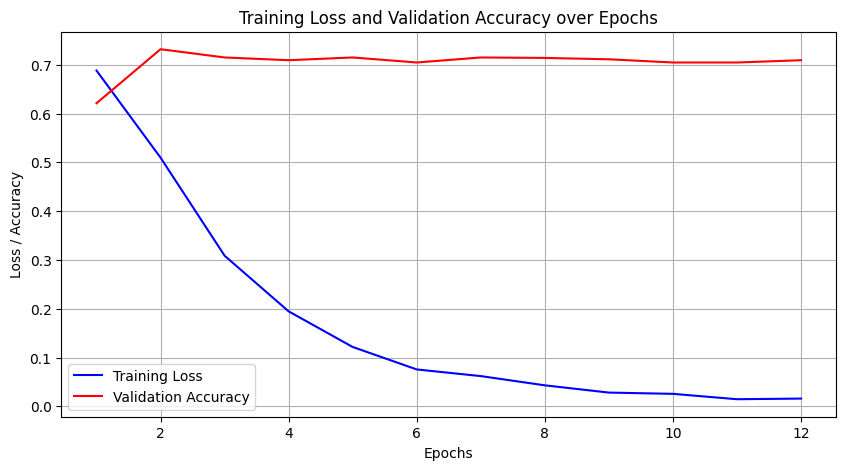

In [37]:
plot_loss_accuracy(losses, accuracies)

In [38]:
attention_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7580


# biGRU model

In [39]:
MODEL_TYPE = "gru"
LR = 0.0001

## Last State

### 2 layers

In [40]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [41]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="last_state",
    freeze_embeddings=False
)

In [42]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6929, Accuracy: 0.5253
Model saved.
Epoch   2/100, Loss: 0.6224, Accuracy: 0.7280
Model saved.
Epoch   3/100, Loss: 0.3686, Accuracy: 0.7242
Epoch   4/100, Loss: 0.2212, Accuracy: 0.7242
Epoch   5/100, Loss: 0.1387, Accuracy: 0.7148
Epoch   6/100, Loss: 0.0837, Accuracy: 0.7139
Epoch   7/100, Loss: 0.0540, Accuracy: 0.7101
Epoch   8/100, Loss: 0.0386, Accuracy: 0.7233
Epoch   9/100, Loss: 0.0262, Accuracy: 0.7176
Epoch  10/100, Loss: 0.0186, Accuracy: 0.7158
Epoch  11/100, Loss: 0.0120, Accuracy: 0.7129
Epoch  12/100, Loss: 0.0093, Accuracy: 0.7045
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


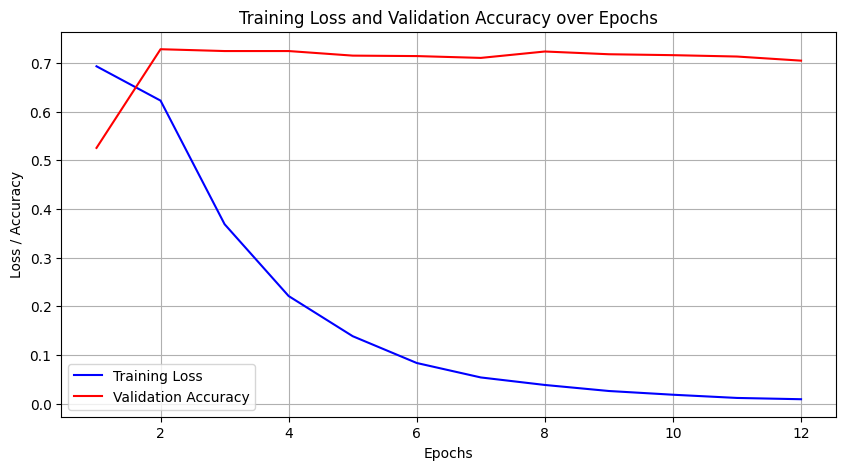

In [43]:
plot_loss_accuracy(losses, accuracies)

In [44]:
last_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7298


### 4 layers

Trying with an increased number of stack layers

In [45]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [46]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="last_state",
    freeze_embeddings=False
)

In [47]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6909, Accuracy: 0.5572
Model saved.
Epoch   2/100, Loss: 0.5530, Accuracy: 0.6867
Model saved.
Epoch   3/100, Loss: 0.3267, Accuracy: 0.7054
Model saved.
Epoch   4/100, Loss: 0.2003, Accuracy: 0.6989
Epoch   5/100, Loss: 0.1252, Accuracy: 0.7045
Epoch   6/100, Loss: 0.0764, Accuracy: 0.7092
Model saved.
Epoch   7/100, Loss: 0.0506, Accuracy: 0.6970
Epoch   8/100, Loss: 0.0328, Accuracy: 0.7054
Epoch   9/100, Loss: 0.0267, Accuracy: 0.7017
Epoch  10/100, Loss: 0.0270, Accuracy: 0.7111
Model saved.
Epoch  11/100, Loss: 0.0183, Accuracy: 0.7054
Epoch  12/100, Loss: 0.0074, Accuracy: 0.7064
Epoch  13/100, Loss: 0.0128, Accuracy: 0.7101
Epoch  14/100, Loss: 0.0038, Accuracy: 0.7120
Model saved.
Epoch  15/100, Loss: 0.0095, Accuracy: 0.7036
Epoch  16/100, Loss: 0.0111, Accuracy: 0.7083
Epoch  17/100, Loss: 0.0079, Accuracy: 0.7083
Epoch  18/100, Loss: 0.0060, Accuracy: 0.7036
Epoch  19/100, Loss: 0.0064, Accuracy: 0.7101
Epoch  20/100, Loss: 0.0045, Accuracy: 0.7054
Ep

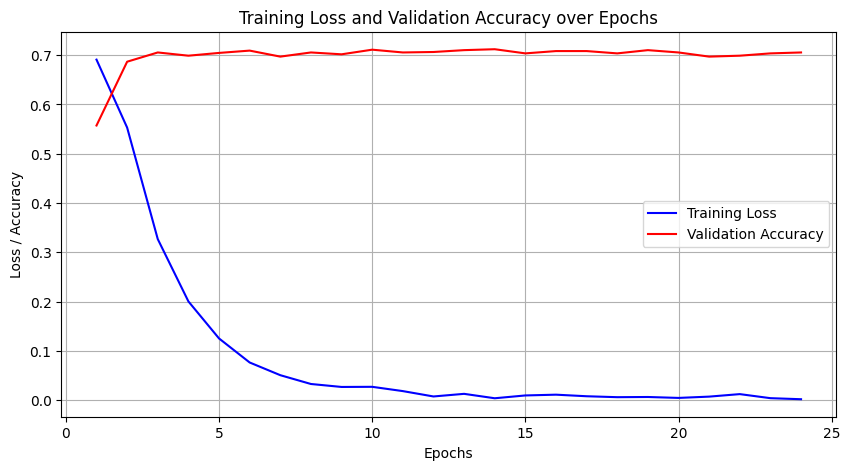

In [48]:
plot_loss_accuracy(losses, accuracies)

In [49]:
last_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7326


## Mean Max Pool

### 2 layers

In [50]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [51]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_max",
    freeze_embeddings=False
)

In [52]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6881, Accuracy: 0.6126
Model saved.
Epoch   2/100, Loss: 0.5227, Accuracy: 0.7251
Model saved.
Epoch   3/100, Loss: 0.3083, Accuracy: 0.7205
Epoch   4/100, Loss: 0.1941, Accuracy: 0.6951
Epoch   5/100, Loss: 0.1235, Accuracy: 0.7176
Epoch   6/100, Loss: 0.0837, Accuracy: 0.7176
Epoch   7/100, Loss: 0.0536, Accuracy: 0.7176
Epoch   8/100, Loss: 0.0395, Accuracy: 0.7148
Epoch   9/100, Loss: 0.0240, Accuracy: 0.7054
Epoch  10/100, Loss: 0.0246, Accuracy: 0.7036
Epoch  11/100, Loss: 0.0176, Accuracy: 0.7129
Epoch  12/100, Loss: 0.0113, Accuracy: 0.7101
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


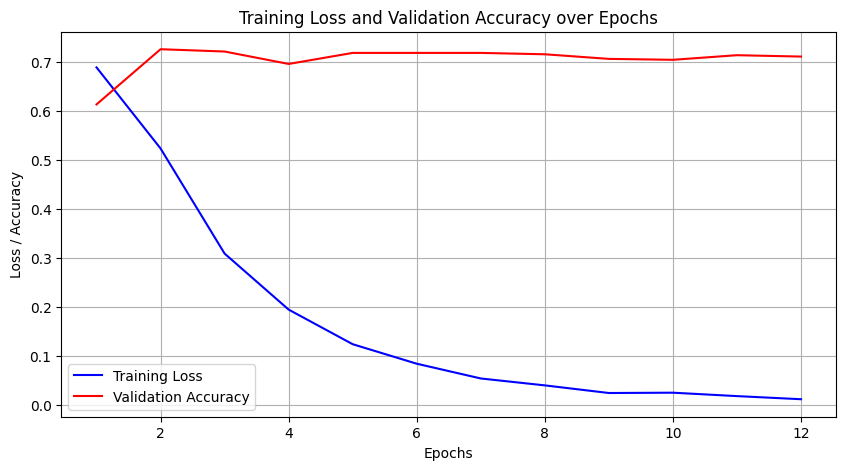

In [53]:
plot_loss_accuracy(losses, accuracies)

In [54]:
mean_max_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7505


### 4 layers

In [55]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [56]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="mean_max",
    freeze_embeddings=False
)

In [57]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6850, Accuracy: 0.6135
Model saved.
Epoch   2/100, Loss: 0.5057, Accuracy: 0.7129
Model saved.
Epoch   3/100, Loss: 0.3104, Accuracy: 0.7111
Epoch   4/100, Loss: 0.1992, Accuracy: 0.6932
Epoch   5/100, Loss: 0.1265, Accuracy: 0.7054
Epoch   6/100, Loss: 0.0796, Accuracy: 0.7139
Model saved.
Epoch   7/100, Loss: 0.0578, Accuracy: 0.7045
Epoch   8/100, Loss: 0.0382, Accuracy: 0.7129
Epoch   9/100, Loss: 0.0266, Accuracy: 0.7026
Epoch  10/100, Loss: 0.0206, Accuracy: 0.7064
Epoch  11/100, Loss: 0.0208, Accuracy: 0.7064
Epoch  12/100, Loss: 0.0125, Accuracy: 0.7129
Epoch  13/100, Loss: 0.0132, Accuracy: 0.7120
Epoch  14/100, Loss: 0.0194, Accuracy: 0.7120
Epoch  15/100, Loss: 0.0093, Accuracy: 0.7120
Epoch  16/100, Loss: 0.0077, Accuracy: 0.7083
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


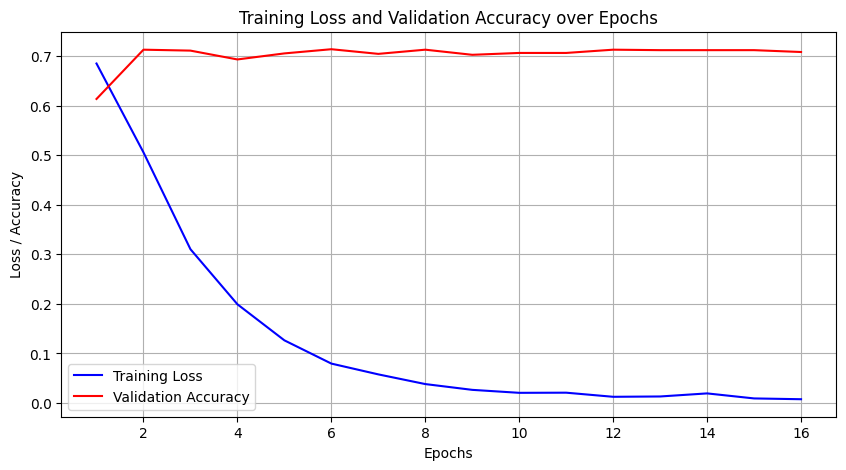

In [58]:
plot_loss_accuracy(losses, accuracies)

In [59]:
mean_max_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7411


## Attention

### 2 layers

In [60]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [61]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="attention",
    freeze_embeddings=False
)

In [62]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6876, Accuracy: 0.5994
Model saved.
Epoch   2/100, Loss: 0.5287, Accuracy: 0.7326
Model saved.
Epoch   3/100, Loss: 0.3183, Accuracy: 0.7298
Epoch   4/100, Loss: 0.2002, Accuracy: 0.7186
Epoch   5/100, Loss: 0.1281, Accuracy: 0.7008
Epoch   6/100, Loss: 0.0847, Accuracy: 0.7101
Epoch   7/100, Loss: 0.0534, Accuracy: 0.7045
Epoch   8/100, Loss: 0.0348, Accuracy: 0.7176
Epoch   9/100, Loss: 0.0268, Accuracy: 0.7054
Epoch  10/100, Loss: 0.0186, Accuracy: 0.7036
Epoch  11/100, Loss: 0.0177, Accuracy: 0.7054
Epoch  12/100, Loss: 0.0102, Accuracy: 0.7139
Early stopping triggered after 12 epochs.
Training ended, loading best model...
Model loaded.


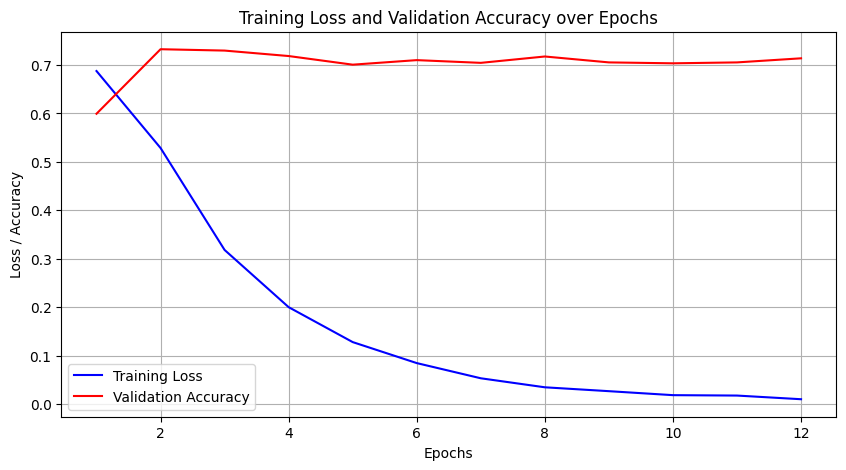

In [63]:
plot_loss_accuracy(losses, accuracies)

In [64]:
attention_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7570


### 4 layers

In [65]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [66]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="attention",
    freeze_embeddings=False
)

In [67]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6843, Accuracy: 0.6107
Model saved.
Epoch   2/100, Loss: 0.5022, Accuracy: 0.6886
Model saved.
Epoch   3/100, Loss: 0.3126, Accuracy: 0.7148
Model saved.
Epoch   4/100, Loss: 0.1919, Accuracy: 0.7017
Epoch   5/100, Loss: 0.1189, Accuracy: 0.7092
Epoch   6/100, Loss: 0.0745, Accuracy: 0.7101
Epoch   7/100, Loss: 0.0496, Accuracy: 0.7054
Epoch   8/100, Loss: 0.0348, Accuracy: 0.6998
Epoch   9/100, Loss: 0.0240, Accuracy: 0.7036
Epoch  10/100, Loss: 0.0257, Accuracy: 0.6970
Epoch  11/100, Loss: 0.0140, Accuracy: 0.6970
Epoch  12/100, Loss: 0.0212, Accuracy: 0.6951
Epoch  13/100, Loss: 0.0103, Accuracy: 0.7073
Early stopping triggered after 13 epochs.
Training ended, loading best model...
Model loaded.


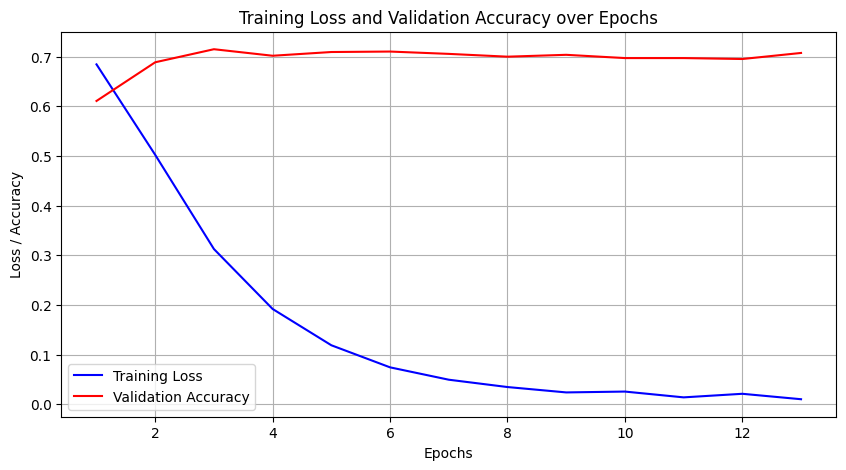

In [68]:
plot_loss_accuracy(losses, accuracies)

In [69]:
attention_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7636


# Results

In [70]:
print("Last state pooling:")
print(f"BiLSTM 2-layer: {last_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {last_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {last_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {last_gru_4_accuracy:.4f}")
print("Mean Max Pooling:")
print(f"BiLSTM 2-layer: {mean_max_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {mean_max_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {mean_max_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {mean_max_gru_4_accuracy:.4f}")
print("Attention:")
print(f"BiLSTM 2-layer: {attention_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {attention_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {attention_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {attention_gru_4_accuracy:.4f}")

Last state pooling:
BiLSTM 2-layer: 0.7439
BiLSTM 4-layer: 0.7627
BiGRU 2-layer:  0.7298
BiGRU 4-layer:  0.7326
Mean Max Pooling:
BiLSTM 2-layer: 0.7570
BiLSTM 4-layer: 0.7523
BiGRU 2-layer:  0.7505
BiGRU 4-layer:  0.7411
Attention:
BiLSTM 2-layer: 0.7505
BiLSTM 4-layer: 0.7580
BiGRU 2-layer:  0.7570
BiGRU 4-layer:  0.7636
